<div style="direction:rtl;text-align:center"><img src="https://dl.mohammadkh.ir/logo.png" alt="Mohammadkh.ir" style="width: 250px;"/></div>
<h1><div style="direction:rtl;text-align:center">Neural Network</div></h1>

In [20]:
import json
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import pickle

,high,low,open,volumefrom,volumeto,close
time,,,,,,
1652572800,31406.35,29462.91,30050.31,26775.50,8.102000e+08,31296.11
1652659200,31297.54,29291.23,31296.11,27601.28,8.287156e+08,29476.24


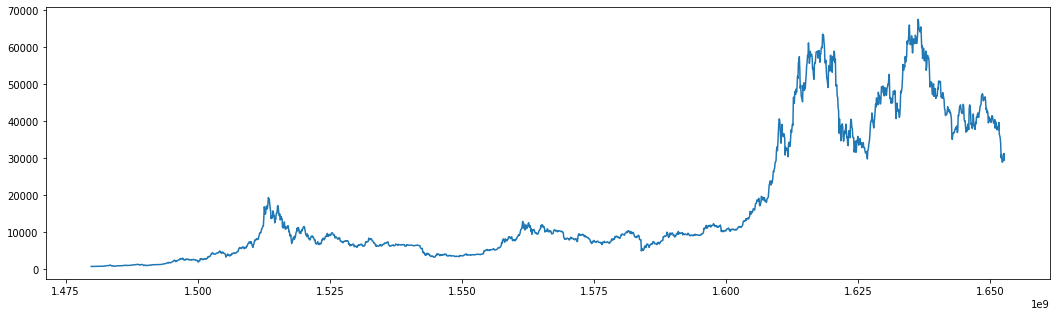

In [88]:
# get request data
# response = requests.get('https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=2000')
# print(json.loads(response.content)['Data']['Data'][-2:])
# df = pd.DataFrame(json.loads(response.content)['Data']['Data'])

with open('../../__data/crypto/btc.daily.2000','rb') as f:
    df = pickle.load(f)

df = df.set_index('time')
df = df[['high', 'low', 'open', 'volumefrom', 'volumeto', 'close']]

fig, ax = plt.subplots(1, figsize=(18, 5))
ax.plot(df['close'], label='data')

df.tail(2)

In [80]:
def train_test_split(df):
    split_row = len(df) - int(0.1 * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def norm_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def norm_zero_base(df):
    return df / df.iloc[0] - 1

def extract_windows_data(df):
    window_data = []
    for idx in range(len(df) - 10):
        tmp = df[idx: (idx + 10)].copy()
        tmp = norm_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df):
    train_data, test_data = train_test_split(df)
    X_train = extract_windows_data(train_data)
    X_test = extract_windows_data(test_data)
    y_train = train_data['close'][10:].values
    y_test = test_data['close'][10:].values
    
    y_train = y_train / train_data['close'][:-10].values - 1
    y_test = y_test / test_data['close'][:-10].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(df)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1791, 10, 6)
(1791,)
(190, 10, 6)
(190,)


In [66]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.add(Activation('relu'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               42800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(loss='mse', optimizer='adam')

In [87]:
history = model.fit(X_train, y_train, epochs=3, batch_size=32, shuffle=True, verbose=1)

Epoch 1/3
56/56 [==============================] - 1s 12ms/step - loss: 0.0071
Epoch 2/3
56/56 [==============================] - 1s 13ms/step - loss: 0.0071
Epoch 3/3
56/56 [==============================] - 1s 13ms/step - loss: 0.0071


In [76]:
targets = test['close'][10:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.06791394391047874

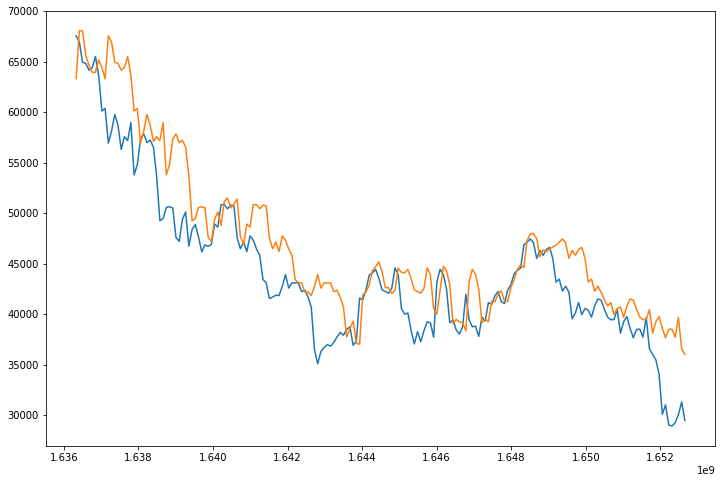

In [79]:
preds_plt = preds.copy()
preds_plt[:190] = test['close'].iloc[:190].values * (preds_plt[:190] + 1)
preds_plt = pd.Series(index=targets.index, data=preds_plt)
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(targets[:190], label='target')
ax.plot(preds_plt[:190], label='predics')

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:left"><strong>Regression</strong><br>MohammadReza <strong>Khajedaloi</strong><br><br>
</div>
<div style="direction:rtl;text-align:right">
<a href="http://mohammadkh.ir/">WebSite</a> - <a href="https://github.com/khajedaloi/">GitHub</a> - <a href="https://www.linkedin.com/in/mohammad-kh/">Linkedin</a>
</div>
</div>